In [217]:
#performs feature extraction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [218]:
#read data for subject 101 from file, coplied mostly from cylin

IMUlabels=['temp']+[x+y for x in ['a16_','a6_','gyro_','B_'] for y in ['x','y','z']]+['orient_'+x for x in ['1','2','3','4']]
col_labels=['time','activity_ID','heart_rate']+[x+y for x in ['hand_','chest_','ankle_'] for y in IMUlabels]
data=pd.read_csv('./PAMAP2_Dataset/Protocol/subject101.dat',sep=' ',names=col_labels,header=None)

In [219]:
#linear interpolate missing data
dataint=data.interpolate(method='linear')

In [220]:
#dictionary converting activity id to activity name
activity_dict={0:'other',1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'nordic walking',
              9:'watching TV',10:'computer work',11:'car driving',12:'ascending stairs',13:'descending stairs',
              16:'vacuum cleaning',17:'ironing',18:'folding laundry',19:'house cleaning',20:'playing_soccer',
              24:'rope jumping'}

#sub column labels to be retained
IMUsublabels=[x+y for x in ['a16_','gyro_','B_'] for y in ['x','y','z']]
col_sublabels=['time','activity_ID','heart_rate']+[x+y for x in ['hand_','chest_','ankle_'] for y in ['temp']+IMUsublabels]

#dictionary converting column name to column index
col_dict={col_sublabels[i]:i for i in range(len(col_sublabels))}

#drop columns for orientation and a_6
data_sub=pd.DataFrame(dataint,columns=col_sublabels)

#drop activity 0
data_nz=data_sub.loc[lambda x:x['activity_ID']!=0]

#convert to numpy: I am not familiar with pandas enough...
data_ar=np.array(data_nz)

#split data into maximal chunks of time, with same activity ids
x=np.arange(len(data_ar))
split_ind=np.argwhere(data_ar[x,1]!=data_ar[x-1,1])[:,0]
split_ind=np.append(split_ind,len(data_ar+1))
chunks=[data_ar[split_ind[i]:split_ind[i+1]] for i in range(len(split_ind)-1)]

#drop the first and last 10 seconds
chunks_chopped=[x[1000:-1000] for x in chunks]

In [221]:
print(col_sublabels)

['time', 'activity_ID', 'heart_rate', 'hand_temp', 'hand_a16_x', 'hand_a16_y', 'hand_a16_z', 'hand_gyro_x', 'hand_gyro_y', 'hand_gyro_z', 'hand_B_x', 'hand_B_y', 'hand_B_z', 'chest_temp', 'chest_a16_x', 'chest_a16_y', 'chest_a16_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_B_x', 'chest_B_y', 'chest_B_z', 'ankle_temp', 'ankle_a16_x', 'ankle_a16_y', 'ankle_a16_z', 'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z', 'ankle_B_x', 'ankle_B_y', 'ankle_B_z']


In [222]:
[(activity_dict[x[0,1]],x.shape) for x in chunks_chopped]

[('lying', (25187, 33)),
 ('sitting', (21480, 33)),
 ('standing', (19717, 33)),
 ('ironing', (21573, 33)),
 ('vacuum cleaning', (20941, 33)),
 ('ascending stairs', (6120, 33)),
 ('descending stairs', (5480, 33)),
 ('ascending stairs', (5770, 33)),
 ('descending stairs', (5419, 33)),
 ('walking', (20253, 33)),
 ('nordic walking', (18265, 33)),
 ('cycling', (21575, 33)),
 ('running', (19265, 33)),
 ('rope jumping', (10912, 33))]

In [223]:
def feat1(blocki):
    #given blocki, a T-dim array, computes mean and std
    mean=np.mean(blocki)
    std=np.std(blocki)
#    peak=np.max(blocki)
    return mean,std

In [224]:
block=chunks_chopped[0][:512]
feat1(block[:,2])

(103.951171875, 0.8054294919368868)

In [225]:
def integral(series,imax=None):
    #given array with positive entries, compute integral along axis 0 up to entry i, normalized such that the integral is 1 when i reaches the end
    if imax==None:
        imax=len(series)
        tot=np.sum(series)
    return np.array([np.sum(series[:i]) for i in range(imax)])/tot

In [226]:
def feat2(blocki,ulist):
    #ulist is a list of numbers {u_i} from 0 to 1. Computes at what frequency omega does the power spectrum integrated from 0 to omega gives u_i of the total.
    T=len(blocki)
    fourier=np.fft.rfft(blocki)
    power_int=integral(abs(fourier)**2)
    freq_list=[np.searchsorted(power_int,u) for u in ulist]
    #peak frequency
#    peak_freq=(np.argmax(abs(fourier)[freq_list[0]:])+freq_list[0])
#    return np.array([peak_freq]+freq_list)*100/T
    return np.array(freq_list)*100/T

In [227]:
def feat3(blockixyz,ulist):
    #similar to feat2, but the power is summed over x,y,z
    T=len(blockixyz[0])
    fourierx=np.fft.rfft(blockixyz[0])
    fouriery=np.fft.rfft(blockixyz[1])
    fourierz=np.fft.rfft(blockixyz[2])
    
    power_int=integral(abs(fourierx)**2+abs(fouriery)**2+abs(fourierz)**2)
    freq_list=[np.searchsorted(power_int,u) for u in ulist]
    return np.array(freq_list)*100/T

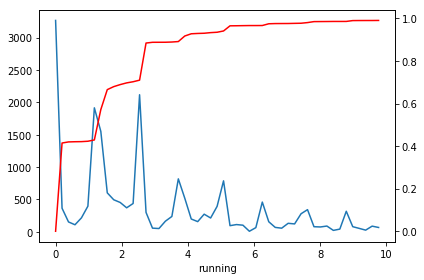

[1.3671875 2.34375   2.734375  3.90625   5.2734375]


In [228]:
#plot of fourier transform of hand_a16_x, and the power spectrum integral. block 5 seconds long. x-axis labels frequency

block=chunks_chopped[-2][:512]
ulist=[0.5,0.7,0.8,0.9,0.95]

T=len(block)
i=block[0,1]
omega=np.arange(T//10)*100/T
fourier=np.fft.rfft(block[:,col_dict['hand_a16_x']])
power_int=integral(abs(fourier)**2)

fig, ax1 = plt.subplots()
ax1.plot(omega, abs(fourier)[:T//10])
ax1.set_xlabel(activity_dict[i])

ax2 = ax1.twinx()
ax2.plot(omega, power_int[:T//10],'r')

fig.tight_layout()
plt.show()
print(feat2(block[:,4],ulist))

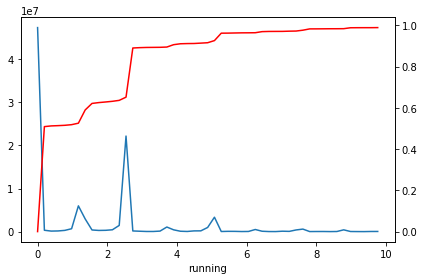

[0.1953125 2.734375  3.90625   5.2734375]


In [229]:
#plot of \sum_i(fourier transform of hand_a16_i)^2, and the power spectrum integral. block 5 seconds long. x-axis labels frequency
block=chunks_chopped[-2][:512]
ulist=[0.5,0.75,0.9,0.95]

T=len(block)
i=block[0,1]
omega=np.arange(T//10)*100/T

nx,ny,nz=[col_dict['hand_a16_'+i] for i in ['x','y','z']]

fourierx=np.fft.rfft(block[:,nx])
fouriery=np.fft.rfft(block[:,ny])
fourierz=np.fft.rfft(block[:,nz])
power_int=integral(abs(fourierx)**2+abs(fouriery)**2+abs(fourierz)**2)

fig, ax1 = plt.subplots()
ax1.plot(omega, (abs(fourierx)**2+abs(fouriery)**2+abs(fourierz)**2)[:T//10])
ax1.set_xlabel(activity_dict[i])

ax2 = ax1.twinx()
ax2.plot(omega, power_int[:T//10],'r')

fig.tight_layout()
plt.show()
print(feat3((block[:,nx],block[:,ny],block[:,nz]),ulist))

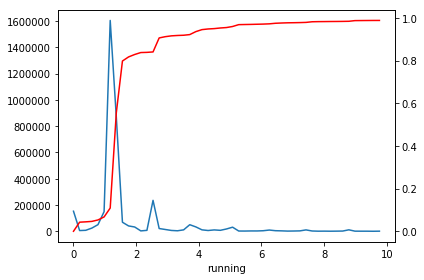

[1.3671875 1.5625    2.734375  4.6875   ]


In [230]:
#same plot for hand_gyro
block=chunks_chopped[-2][:512]
ulist=[0.5,0.75,0.9,0.95]

T=len(block)
i=block[0,1]
omega=np.arange(T//10)*100/T

nx,ny,nz=[col_dict['hand_gyro_'+i] for i in ['x','y','z']]

fourierx=np.fft.rfft(block[:,nx])
fouriery=np.fft.rfft(block[:,ny])
fourierz=np.fft.rfft(block[:,nz])
power_int=integral(abs(fourierx)**2+abs(fouriery)**2+abs(fourierz)**2)

fig, ax1 = plt.subplots()
ax1.plot(omega, (abs(fourierx)**2+abs(fouriery)**2+abs(fourierz)**2)[:T//10])
ax1.set_xlabel(activity_dict[i])

ax2 = ax1.twinx()
ax2.plot(omega, power_int[:T//10],'r')

fig.tight_layout()
plt.show()
print(feat3((block[:,nx],block[:,ny],block[:,nz]),[0.5,0.75,0.9,0.95]))

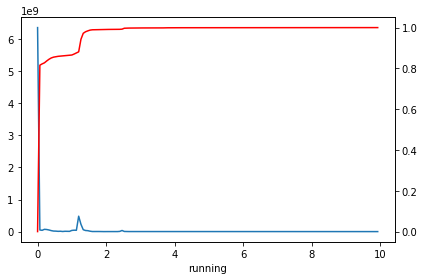

[0.06666667 0.06666667 1.26666667 1.33333333]


In [231]:
#same plot for hand_B

block=chunks_chopped[-2][:1500]
ulist=[0.5,0.75,0.9,0.95]

T=len(block)
i=block[0,1]
omega=np.arange(T//10)*100/T

nx,ny,nz=[col_dict['hand_B_'+i] for i in ['x','y','z']]

fourierx=np.fft.rfft(block[:,nx])
fouriery=np.fft.rfft(block[:,ny])
fourierz=np.fft.rfft(block[:,nz])
power_int=integral(abs(fourierx)**2+abs(fouriery)**2+abs(fourierz)**2)

fig, ax1 = plt.subplots()
ax1.plot(omega, (abs(fourierx)**2+abs(fouriery)**2+abs(fourierz)**2)[:T//10])
ax1.set_xlabel(activity_dict[i])

ax2 = ax1.twinx()
ax2.plot(omega, power_int[:T//10],'r')

fig.tight_layout()
plt.show()
print(feat3((block[:,nx],block[:,ny],block[:,nz]),ulist))

In [232]:
#feature names

def feat1name(s):
    return [s+x for x in ['mean','std']]

def feat2name(s,ulist):
    return [s+'freq_'+str(x) for x in ulist]

def feat_names(ulist):
    names=feat1name('heart_rate_')
    for part in ['hand_','chest_','ankle_']:
        names+=feat1name(part+'temp_')
        for subl1 in ['a16_','gyro_','B_']:
            for subl2 in ['x_','y_','z_']:
                names+=feat1name(part+subl1+subl2)
            names+=feat2name(part+subl1,ulist)
    return names

In [233]:
ulist=[0.5,0.75,0.9,0.95]
feat_names(ulist)

['heart_rate_mean',
 'heart_rate_std',
 'hand_temp_mean',
 'hand_temp_std',
 'hand_a16_x_mean',
 'hand_a16_x_std',
 'hand_a16_y_mean',
 'hand_a16_y_std',
 'hand_a16_z_mean',
 'hand_a16_z_std',
 'hand_a16_freq_0.5',
 'hand_a16_freq_0.75',
 'hand_a16_freq_0.9',
 'hand_a16_freq_0.95',
 'hand_gyro_x_mean',
 'hand_gyro_x_std',
 'hand_gyro_y_mean',
 'hand_gyro_y_std',
 'hand_gyro_z_mean',
 'hand_gyro_z_std',
 'hand_gyro_freq_0.5',
 'hand_gyro_freq_0.75',
 'hand_gyro_freq_0.9',
 'hand_gyro_freq_0.95',
 'hand_B_x_mean',
 'hand_B_x_std',
 'hand_B_y_mean',
 'hand_B_y_std',
 'hand_B_z_mean',
 'hand_B_z_std',
 'hand_B_freq_0.5',
 'hand_B_freq_0.75',
 'hand_B_freq_0.9',
 'hand_B_freq_0.95',
 'chest_temp_mean',
 'chest_temp_std',
 'chest_a16_x_mean',
 'chest_a16_x_std',
 'chest_a16_y_mean',
 'chest_a16_y_std',
 'chest_a16_z_mean',
 'chest_a16_z_std',
 'chest_a16_freq_0.5',
 'chest_a16_freq_0.75',
 'chest_a16_freq_0.9',
 'chest_a16_freq_0.95',
 'chest_gyro_x_mean',
 'chest_gyro_x_std',
 'chest_gyro_y

In [234]:
def feat_row(block,ulist):
    #extract features from block. uses feat1 for all variables, uses feat3 for a16,gyro and B data
    heart_feat=feat1(block[:,col_dict['heart_rate']])
    all_feat=heart_feat
    for part in ['hand_','chest_','ankle_']:
        part_feat=feat1(block[:,col_dict[part+'temp']])
        for subl1 in ['a16_','gyro_','B_']:
            for subl2 in ['x','y','z']:
                part_feat=np.concatenate((part_feat,feat1(block[:,col_dict[part+subl1+subl2]])))
            nx,ny,nz=[col_dict[part+subl1+i] for i in ['x','y','z']]
            part_feat=np.concatenate((part_feat,feat3((block[:,nx],block[:,ny],block[:,nz]),ulist)))
        all_feat=np.concatenate((all_feat,part_feat))
    return all_feat

In [235]:
#total no of features: 98=( 2*(1+3*(1+3*3))=62 from feat1, plus 4*(3*3)=36 from feat3 )
feat_row(block,ulist).shape

(98,)

In [236]:
#collect data into traindata and trainlabels

traindata=np.empty((0,98))
trainlabels=np.empty((0))
T=512
stride=100
for chunki in chunks_chopped:
    imax=(len(chunki)-T)//stride
    for i in range(imax):
        feat_rowi=feat_row(chunki[i*stride:i*stride+T],ulist)
        traindata=np.append(traindata,[feat_rowi],axis=0)
        trainlabels=np.append(trainlabels,chunki[0,1])

In [248]:
#very clumsy way to attach label column to data matrix. sorry
datalabels=np.hstack((traindata,np.reshape(trainlabels,(len(trainlabels),1))))

np.save('data1.npy', (feat_names(ulist),datalabels))